In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from PIL import Image
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, Flatten, Dense, GlobalAveragePooling2D)
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_dir = "/content/drive/MyDrive/AI last sem/week5/FruitinAmazon/train"

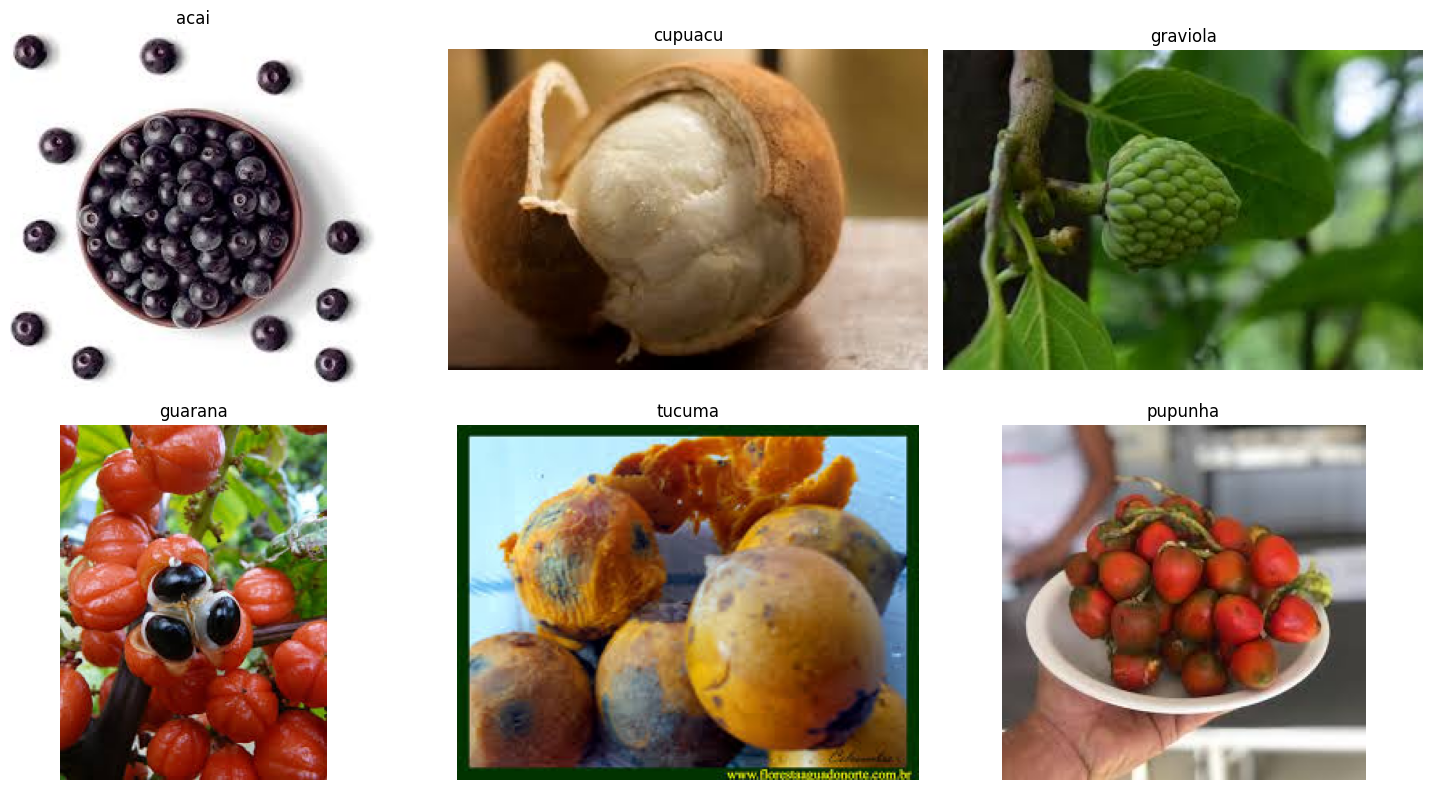

In [ ]:
classes = os.listdir(train_dir)


selected_images = []
selected_labels = []

for class_name in classes:
    class_dir = os.path.join(train_dir, class_name)
    image_files = os.listdir(class_dir)

    if len(image_files) > 0:
        image_path = os.path.join(class_dir, image_files[0])
        selected_images.append(image_path)
        selected_labels.append(class_name)

num_classes = len(selected_images)
n_cols = (num_classes + 1) // 2
fig, axes = plt.subplots(nrows=2, ncols=n_cols, figsize=(15, 8))
axes = axes.flatten()

for i, (img_path, label) in enumerate(zip(selected_images, selected_labels)):
    img = load_img(img_path)
    axes[i].imshow(img)
    axes[i].set_title(label)
    axes[i].axis('off')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
corrupted_images = []
for class_name in classes:
    class_dir = os.path.join(train_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        try:
            img = Image.open(image_path)
            img.verify()
        except (IOError, SyntaxError) as e:
            corrupted_images.append(image_path)
            os.remove(image_path)
            print(f"Removed corrupted image: {image_path}")


if corrupted_images:
    print("Corrupted images found:")
    for image_path in corrupted_images:
        print(image_path)
else:
    print("No corrupted images found.")

No corrupted images found.


In [ ]:
# Dictionary to store class counts
class_counts = {}
for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(images) # Count images in each class
# Print Class Balance
print("\nClass Distribution:")
print("=" * 45)
print(f"{'Class Name':<25}{'Valid Image Count':>15}")
print("=" * 45)
for class_name, count in class_counts.items():
    print(f"{class_name:<25}{count:>15}")
print("=" * 45)


Class Distribution:
Class Name               Valid Image Count
acai                                  15
cupuacu                               15
graviola                              15
guarana                               15
tucuma                                15
pupunha                               15


In [ ]:

data_generator = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255,  # Normalize pixel values to [0, 1]
    validation_split=0.2
)

train_data = data_generator.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='sparse',
    subset='training',
    seed=1337
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


validation_data = val_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='sparse',
    subset='validation',
    seed=1337,
    shuffle=False
)

Found 72 images belonging to 6 classes.
Found 18 images belonging to 6 classes.


In [ ]:
image_size = (128, 128)
batch_size = 64

# Model improvement

In [ ]:
def create_model (input_shape, classes=6):
  model = keras.Sequential([

        layers.Input(shape=input_shape),


        layers.Conv2D(32, (3, 3), padding='same', activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),


        layers.Conv2D(64, (3, 3), padding='same', activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),


        layers.Conv2D(128, (3, 3), padding='same', activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.35),

        layers.Flatten(),
        layers.Dense(256, activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),

        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])

  return model


In [ ]:
curr_model = create_model((128, 128, 3))

curr_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,099,238 (34.71 MB)

 Trainable params: 9,096,358 (34.70 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [ ]:
history = curr_model.fit(train_data,epochs=20,validation_data=validation_data,callbacks=[
    EarlyStopping(patience=3,restore_best_weights=True),
    ModelCheckpoint("model.h5",save_best_only=True)
])

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7292 - loss: 0.6888   

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.7222 - loss: 0.7001 - val_accuracy: 0.3333 - val_loss: 2.0428
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 625ms/step - accuracy: 0.6053 - loss: 1.0067 - val_accuracy: 0.2778 - val_loss: 2.1356
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.7778 - loss: 0.5921 - val_accuracy: 0.3889 - val_loss: 2.1988
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6065 - loss: 1.1496 - val_accuracy: 0.3889 - val_loss: 2.3209


In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
class_names = sorted(os.listdir(train_dir))
print(class_names)

['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


In [ ]:
from sklearn.metrics import classification_report

y_pred = np.argmax(curr_model.predict(validation_data), axis=1)

y_true = validation_data.classes

print(classification_report(y_true, y_pred, target_names=validation_data.class_indices.keys(),zero_division=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
              precision    recall  f1-score   support

        acai       0.00      0.00      0.00         3
     cupuacu       0.20      1.00      0.33         3
    graviola       1.00      0.33      0.50         3
     guarana       0.00      0.00      0.00         3
     pupunha       0.00      0.00      0.00         3
      tucuma       1.00      0.67      0.80         3

    accuracy                           0.33        18
   macro avg       0.37      0.33      0.27        18
weighted avg       0.37      0.33      0.27        18



In [ ]:
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

vgg16_model.trainable = True

for layer in vgg16_model.layers[:-4]:

    layer.trainable = False


for layer in vgg16_model.layers:
    print(layer.name, layer.trainable)


input_layer_17 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [ ]:
vgg16_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
x  = vgg16_model.output


x = GlobalAveragePooling2D()(x)


predictions = Dense(len(class_names),activation="softmax")(x)


curr_vgg_model = models.Model(inputs=vgg16_model.input, outputs=predictions)

In [ ]:
curr_vgg_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='training',
    seed=1337
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation',
    seed=1337
)

# Fine-tune the VGG16 model with the new image size and generators
curr_vgg_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = curr_vgg_model.fit(
    train_generator,
    epochs=20,  # Adjust the number of epochs as needed
    validation_data=validation_generator,
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True),
        ModelCheckpoint("vgg16_model.h5", save_best_only=True)
    ]
)


Found 72 images belonging to 6 classes.
Found 18 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.2148 - loss: 1.9360 

3/3 ━━━━━━━━━━━━━━━━━━━━ 50s 22s/step - accuracy: 0.2097 - loss: 1.9150 - val_accuracy: 0.3889 - val_loss: 1.6504
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.3692 - loss: 1.6321

3/3 ━━━━━━━━━━━━━━━━━━━━ 43s 13s/step - accuracy: 0.3741 - loss: 1.6365 - val_accuracy: 0.3333 - val_loss: 1.5449
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.5295 - loss: 1.3891 

3/3 ━━━━━━━━━━━━━━━━━━━━ 43s 13s/step - accuracy: 0.5326 - loss: 1.3881 - val_accuracy: 0.5000 - val_loss: 1.3137
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.5757 - loss: 1.2300

3/3 ━━━━━━━━━━━━━━━━━━━━ 82s 14s/step - accuracy: 0.5776 - loss: 1.2230 - val_accuracy: 0.6111 - val_loss: 1.2048
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6192 - loss: 1.0327  

3/3 ━━━━━━━━━━━━━━━━━━━━ 43s 13s/step - accuracy: 0.6241 - loss: 1.0306 - val_accuracy: 0.7778 - val_loss: 0.8944
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 42s 13s/step - accuracy: 0.8307 - loss: 0.8526 - val_accuracy: 0.6667 - val_loss: 0.9902
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 21s/step - accuracy: 0.7951 - loss: 0.7615 - val_accuracy: 0.6667 - val_loss: 0.9641
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 42s 13s/step - accuracy: 0.7973 - loss: 0.5413 - val_accuracy: 0.6667 - val_loss: 0.9148


In [ ]:

y_pred = np.argmax(curr_vgg_model.predict(validation_generator), axis=1)

y_true = validation_generator.classes

print(classification_report(y_true, y_pred, target_names=validation_generator.class_indices.keys(),zero_division=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
              precision    recall  f1-score   support

        acai       0.50      0.67      0.57         3
     cupuacu       0.20      0.33      0.25         3
    graviola       0.00      0.00      0.00         3
     guarana       0.00      0.00      0.00         3
     pupunha       0.00      0.00      0.00         3
      tucuma       0.00      0.00      0.00         3

    accuracy                           0.17        18
   macro avg       0.12      0.17      0.14        18
weighted avg       0.12      0.17      0.14        18



In [ ]:
x  = vgg16_model.output


x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)

predictions = Dense(len(class_names),activation="softmax")(x)


final_model = models.Model(inputs=vgg16_model.input, outputs=predictions)


In [ ]:
final_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = final_model.fit(
    train_generator,
    epochs=20,  # Adjust the number of epochs as needed
    validation_data=validation_generator,
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True),
        ModelCheckpoint("vgg16_model.h5", save_best_only=True)
    ]
)


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.1777 - loss: 1.8834 

3/3 ━━━━━━━━━━━━━━━━━━━━ 53s 15s/step - accuracy: 0.1923 - loss: 1.8701 - val_accuracy: 0.6111 - val_loss: 1.4971
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.5551 - loss: 1.4660

3/3 ━━━━━━━━━━━━━━━━━━━━ 43s 14s/step - accuracy: 0.5483 - loss: 1.4606 - val_accuracy: 0.5000 - val_loss: 1.2045
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4676 - loss: 1.2547  

3/3 ━━━━━━━━━━━━━━━━━━━━ 42s 13s/step - accuracy: 0.4826 - loss: 1.2378 - val_accuracy: 0.6667 - val_loss: 1.0054
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7957 - loss: 0.8605 

3/3 ━━━━━━━━━━━━━━━━━━━━ 47s 15s/step - accuracy: 0.7912 - loss: 0.8655 - val_accuracy: 0.6667 - val_loss: 0.8743
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7572 - loss: 0.7341

3/3 ━━━━━━━━━━━━━━━━━━━━ 43s 13s/step - accuracy: 0.7623 - loss: 0.7248 - val_accuracy: 0.6667 - val_loss: 0.8084
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7900 - loss: 0.5636

3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 15s/step - accuracy: 0.7835 - loss: 0.5889 - val_accuracy: 0.8333 - val_loss: 0.6604
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8356 - loss: 0.4759 

3/3 ━━━━━━━━━━━━━━━━━━━━ 42s 13s/step - accuracy: 0.8316 - loss: 0.4822 - val_accuracy: 0.8333 - val_loss: 0.6017
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.7750 - loss: 0.4606 

3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 21s/step - accuracy: 0.8000 - loss: 0.4412 - val_accuracy: 0.8889 - val_loss: 0.4462
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 42s 13s/step - accuracy: 0.8547 - loss: 0.3246 - val_accuracy: 0.7778 - val_loss: 0.8205
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 43s 13s/step - accuracy: 0.9171 - loss: 0.2990 - val_accuracy: 0.8333 - val_loss: 0.4718
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 81s 13s/step - accuracy: 0.9168 - loss: 0.2765 - val_accuracy: 0.7778 - val_loss: 0.5484


In [ ]:
best_model = keras.models.load_model("vgg16_model.h5")

In [ ]:
best_model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,246,152 (58.16 MB)

 Trainable params: 7,610,886 (29.03 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 2 (12.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Accuracy: 0.2222222222222222
Precision: 0.2222222222222222
Recall: 0.2222222222222222
F1-score: 0.21746031746031746
Confusion Matrix:
[[0 0 1 0 0 2]
 [0 2 1 0 0 0]
 [1 0 1 0 0 1]
 [1 0 0 1 0 1]
 [0 1 0 1 0 1]
 [0 1 0 0 2 0]]


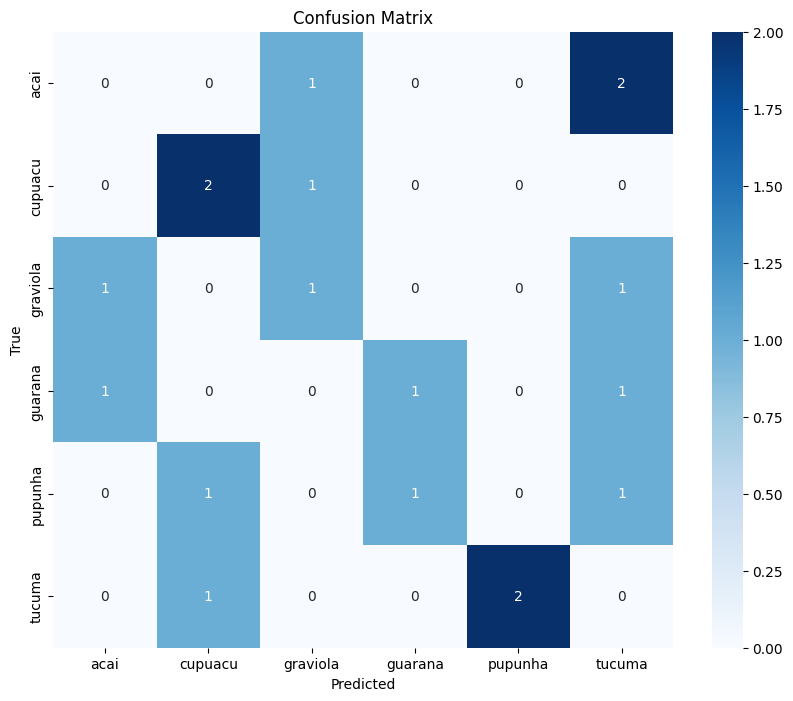

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


y_pred = np.argmax(best_model.predict(validation_generator), axis=1)
y_true = validation_generator.classes

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=validation_generator.class_indices.keys(),
            yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
